# Intergalactic propagation of gamma rays

This notebook exemplifies how to simulate the propagation of gamma ray over cosmological distances
It considers an astrophysical object at a given distance emitting gamma rays according to a power law $E^{-\alpha}$, with an exponential cut-off at a characteristic energy $E_\mathrm{max}$.
The simulation is done assuming this spectrum to be E^-1, but at the post-processing stage any desired spectral index can be obtained.
The object in question is the extreme blazar 1ES 0229+200.

(This simulations may take a couple of minutes.)

In [1]:
from crpropa import *

# general options
nEvents = 20000
energyMinimum = 1 * GeV
energyMaximum = 400 * TeV
redshift = 0.14
distance = redshift2ComovingDistance(redshift)

cmb = CMB()
ebl = IRB_Gilmore12()
outputFile = 'sim/04-sim_1ES0229.txt'

# source distribution: uniform with power-law spectrum
position = SourcePosition(Vector3d(distance, 0, 0))
direction = SourceDirection(Vector3d(-1, 0, 0)) # emit in the -x direction (1D simulation)
redshifts = SourceRedshift1D() # takes the positions and assign the corresponding redshifts
energySpectrum = SourcePowerLawSpectrum(energyMinimum, energyMaximum, -1)
particleType = SourceParticleType(22) # we are interested in gamma rays
source = Source()
source.add(position)
source.add(redshifts) 
source.add(direction)
source.add(energySpectrum)
source.add(particleType)

# output
outputType = Output.Event1D
output = TextOutput(outputFile, outputType)
output.disable(output.CandidateTagColumn)
output.setEnergyScale(eV)
output.setLengthScale(Mpc)

# observer 
observerType = Observer1D()
observer = Observer()
observer.add(observerType)
observer.onDetection(output)

# interactions
ppCMB = EMPairProduction(cmb)
ppEBL = EMPairProduction(ebl)
icsCMB = EMInverseComptonScattering(cmb)
icsEBL = EMInverseComptonScattering(ebl)
z = Redshift()
processes = [ppCMB, ppEBL, icsCMB, icsEBL, z]

# propagator: one-dimensional
propagator = SimplePropagation(0.1 * kpc, 1 * Mpc)

# break conditions
breakTrajectory = MaximumTrajectoryLength(1000 * Mpc)
breakEnergy = MinimumEnergy(1 * GeV)

# assemble simulation components
sim = ModuleList()
sim.add(propagator)
for interaction in processes:
	sim.add(interaction)
sim.add(observer)
sim.add(breakEnergy)
sim.add(breakTrajectory)
sim.setShowProgress(True)
sim.run(source, nEvents, True)

output.close()


crpropa::ModuleList: Number of Threads: 10
Run ModuleList
  Started Sun Aug 20 13:53:06 2023 : [ Finished ] 100%    Needed: 00:00:00  - Finished at Sun Aug 20 13:53:06 2023


Now we proceed with the postprocessing of the simulation.
Note that we wish to simulate a spectrum $E^{-\alpha}$ with an exponential cut-off at rigidities $R_\mathrm{max}$.
Since we simulated a $E_0^{-1}$ spectrum, we must reweight the simulation to obtain the desired injection spectrum.

Functions for reading the simulations and obtaining the spectrum are provided below, including this reweighting procedure.
They are almost the same as in example 03 (for UHECRs), with suitable adjustments for this particular case.

In [3]:
import numpy as np
import pandas as pd


def readSimulation(filename):
	"""
	Read a simulation and return a pandas dataframe with the output.
	"""
	# infer header names
	with open(filename, 'r') as f:
		line = f.readline()
		line = line.replace('\n', '').replace('#', '')
		names = line.split('\t')[1:]
	
	# read file
	df = pd.read_csv(outputFile, delimiter = '\t', comment = '#', names = names)

	return df

def reweightSimulation(df, alpha, Emax, columnName = 'W1', alpha0 = 1.):
	"""
	Given a pandas dataframe with the simulation, this function the correct weights (called `W1`)
	The simulation is assumed to have a spectrum E^-a0, with a0=1 in this case.

	# Input
	. `df`: pandas dataframe containing the simulations \\
	. `alpha`: desired spectral index \\
	. `Emax`: spectrum cuts off above Emax \\
	. `columnName`: name of the column to be created; defaults to 'W1' \\
	. `alpha0`: injection spectrum used in the simulation \\
	"""
	# compute weights for reweighting procedure
	computeWeight = lambda e0: e0 ** (alpha0 - alpha) * np.exp(- e0 / (Emax))
	w = np.array([computeWeight(df['E0'][i]) for i in range(len(df['E0']))])
	df[columnName] = w / np.sum(w)


def computeSpectrum(df, columnName = 'W1'):
	"""
	For a reweighted dataframe with an existing column named 'columnName', computes the spectrum.
	Note that 

	# Input
	. `df`: the dataframe \\
	. `columnName`: the name of the column from where the weights will be taken \\
	"""
	bins = np.logspace(9, 15, 31, endpoint = True)
	y, edges = np.histogram(df['E'], bins = bins, weights = df[columnName])
	x = edges[:-1] + ((edges[1:] - edges[:-1]) / 2.)
	y /= np.diff(edges)
	y *= (x ** 2) # for E^2 dN/dE
	y /= np.amax(y)

	return x, y

Now we will plot the spectrum for this object.

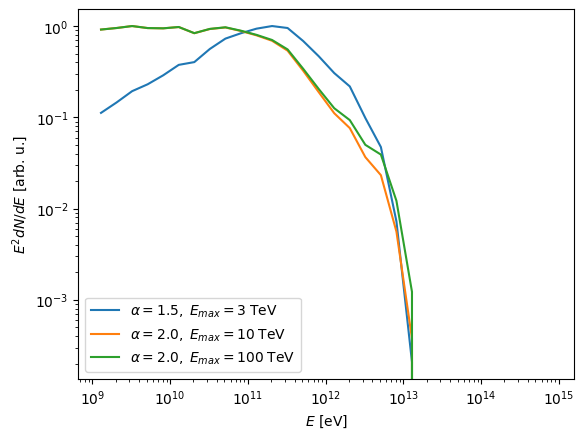

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

data = readSimulation(outputFile)
reweightSimulation(data, 1.5, 3e12, columnName = 'W1')
reweightSimulation(data, 2.0, 1e13, columnName = 'W2')
reweightSimulation(data, 2.0, 1e14, columnName = 'W3')
x1, y1 = computeSpectrum(data, columnName = 'W1')
x2, y2 = computeSpectrum(data, columnName = 'W2')
x3, y3 = computeSpectrum(data, columnName = 'W3')


plt.plot(x1, y1, label = '$\\alpha = 1.5, \\; E_{max} = 3 \\; \\mathrm{TeV}$')
plt.plot(x2, y2, label = '$\\alpha = 2.0, \\; E_{max} = 10 \\; \\mathrm{TeV}$')
plt.plot(x3, y3, label = '$\\alpha = 2.0, \\; E_{max} = 100 \\; \\mathrm{TeV}$')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('$E^2 dN/dE$ [arb. u.]')
plt.xlabel('$E$ [eV]')
plt.legend(loc = 'lower left')

